In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

from sklearn.feature_selection import mutual_info_classif, mutual_info_regression
from sklearn.decomposition import PCA
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

warnings.filterwarnings("ignore", category=FutureWarning)

/kaggle/input/gym-membership-dataset/gym_membership.csv


In [2]:
file_name = '/kaggle/input/gym-membership-dataset/gym_membership.csv'
gym_df = pd.read_csv(file_name, index_col='id')

In [3]:
gym_df.dtypes

gender                   object
birthday                 object
Age                       int64
abonoment_type           object
visit_per_week            int64
days_per_week            object
attend_group_lesson        bool
fav_group_lesson         object
avg_time_check_in        object
avg_time_check_out       object
avg_time_in_gym           int64
drink_abo                  bool
fav_drink                object
personal_training          bool
name_personal_trainer    object
uses_sauna                 bool
dtype: object

In [4]:
gym_df.head()

,gender,birthday,Age,abonoment_type,visit_per_week,days_per_week,attend_group_lesson,fav_group_lesson,avg_time_check_in,avg_time_check_out,avg_time_in_gym,drink_abo,fav_drink,personal_training,name_personal_trainer,uses_sauna
id,,,,,,,,,,,,,,,,
1,Female,1997-04-18,27,Premium,4,"Mon, Sat, Tue, Wed",True,"Kickboxen, BodyPump, Zumba",19:31:00,21:27:00,116,False,NaN,False,NaN,True
2,Female,1977-09-18,47,Standard,3,"Mon, Sat, Wed",False,NaN,19:31:00,20:19:00,48,False,NaN,True,Chantal,False
3,Male,1983-03-30,41,Premium,1,Sat,True,XCore,08:29:00,10:32:00,123,True,"berry_boost, lemon",True,Mike,False
4,Male,1980-04-12,44,Premium,3,"Sat, Tue, Wed",False,NaN,09:54:00,11:33:00,99,True,passion_fruit,True,Mike,True
5,Male,1980-09-10,44,Standard,2,"Thu, Wed",True,"Running, Yoga, Zumba",08:29:00,09:19:00,50,False,NaN,True,Mike,False


In [5]:
gym_df['birthday'] = pd.to_datetime(gym_df['birthday'], format='%Y-%m-%d')
gym_df['avg_time_check_in'] = pd.to_timedelta(gym_df['avg_time_check_in'])
gym_df['avg_time_check_out'] = pd.to_timedelta(gym_df['avg_time_check_out'])

In [6]:
gym_df.duplicated().sum()

0

In [7]:
gym_df.isna().sum()

gender                     0
birthday                   0
Age                        0
abonoment_type             0
visit_per_week             0
days_per_week              0
attend_group_lesson        0
fav_group_lesson         497
avg_time_check_in          0
avg_time_check_out         0
avg_time_in_gym            0
drink_abo                  0
fav_drink                504
personal_training          0
name_personal_trainer    482
uses_sauna                 0
dtype: int64

In [8]:
gym_df[gym_df['drink_abo'] & gym_df['fav_drink'].isna()].shape

(0, 16)

In [9]:
gym_df[gym_df['personal_training'] & gym_df['name_personal_trainer'].isna()].shape

(0, 16)

In [10]:
gym_df[gym_df['attend_group_lesson'] & gym_df['fav_group_lesson'].isna()].shape

(0, 16)

In [11]:
# It seems that NaN values are reasonable here.

<Figure size 1200x1200 with 0 Axes>

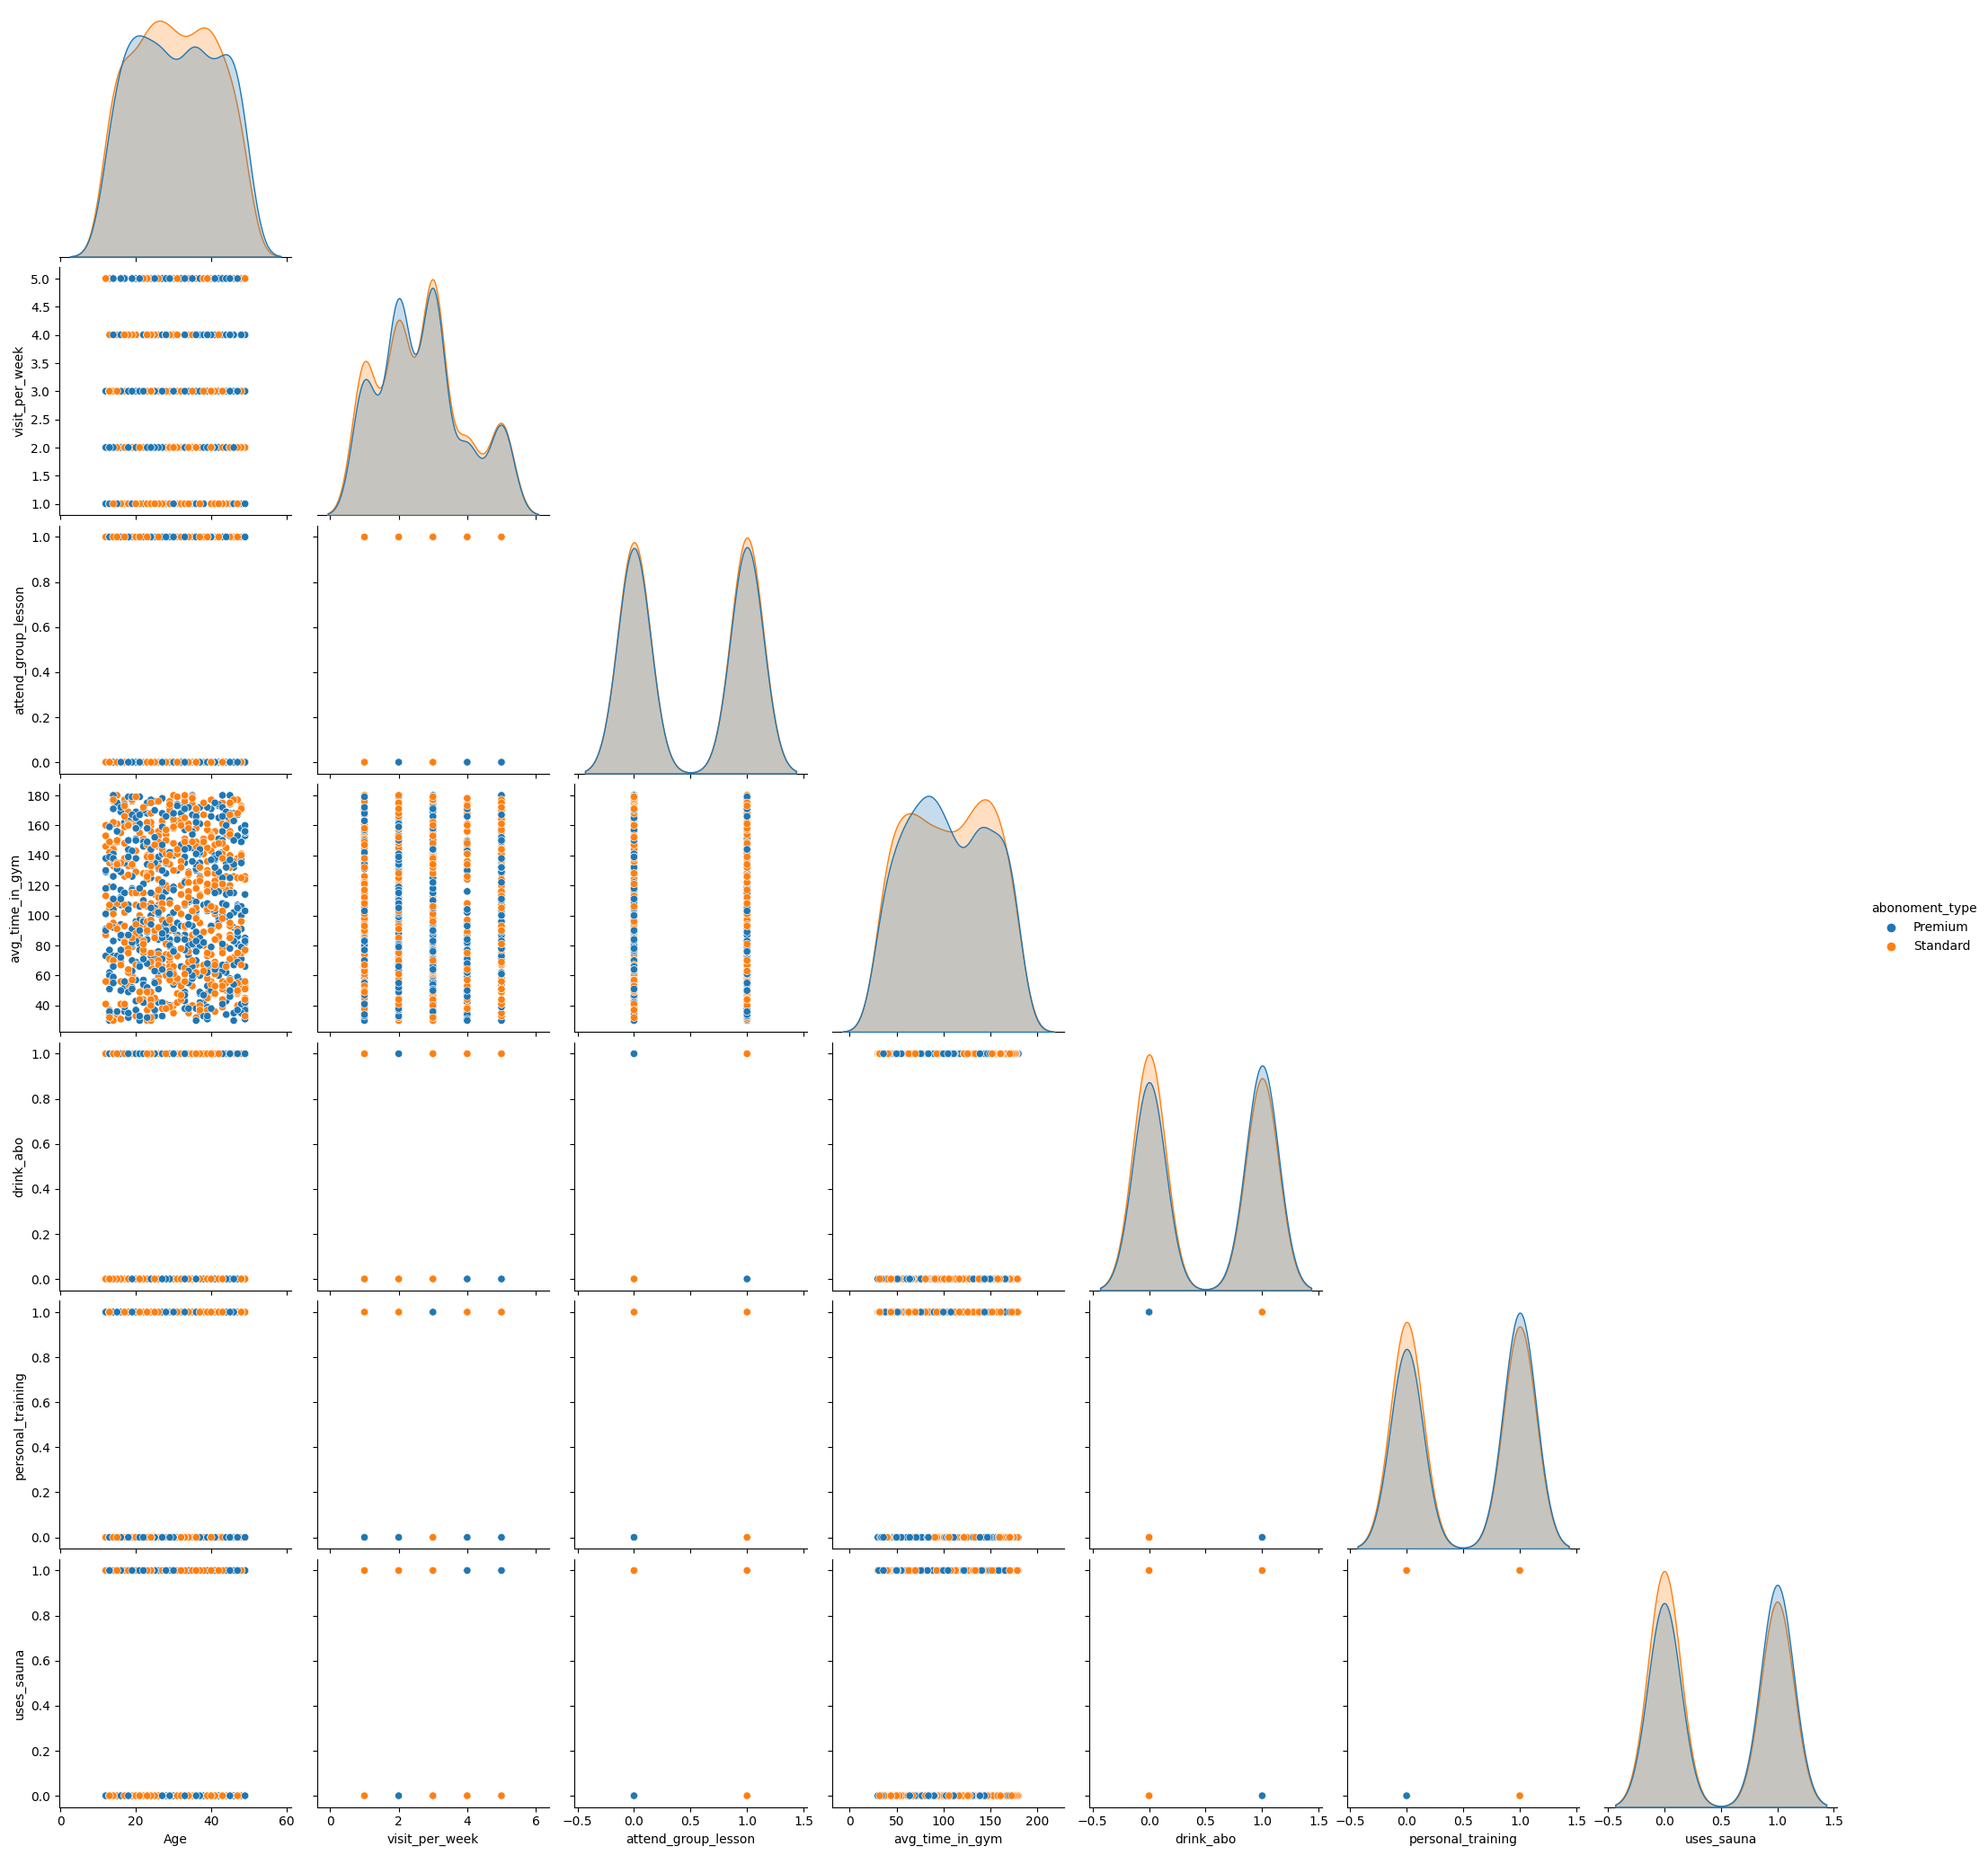

In [12]:
plt.figure(figsize=(12, 12))
sns.pairplot(gym_df, hue='abonoment_type', corner=True, height=3, aspect=1,)

In [13]:
gym_df['name_personal_trainer'].unique()

array([nan, 'Chantal', 'Mike', 'Jeffrey', 'Hanna'], dtype=object)

In [14]:
for colname in ['gender', 'abonoment_type', 'name_personal_trainer']:
    gym_df[colname], _ = gym_df[colname].factorize()

In [15]:
gym_df.loc[~gym_df['fav_drink'].isna(), 'fav_drink'].str.split(', ').explode().unique()

array(['berry_boost', 'lemon', 'passion_fruit', 'coconut_pineapple',
       'orange', 'black_currant'], dtype=object)

In [16]:
gym_df.loc[~gym_df['fav_group_lesson'].isna(), 'fav_group_lesson'].str.split(', ').explode().unique()

array(['Kickboxen', 'BodyPump', 'Zumba', 'XCore', 'Running', 'Yoga',
       'LesMiles', 'Pilates', 'HIT', 'Spinning', 'BodyBalance'],
      dtype=object)

In [17]:
def one_hot_enc(df, col_name, prefix='', separator=', '):
    split_col_name = col_name + '_split'
    df[split_col_name] = df[col_name].str.split(', ')
    df_exploded = df[split_col_name].explode()
    encoded_df = pd.get_dummies(df_exploded, prefix=prefix)
    res = df.join(encoded_df.groupby(df_exploded.index).sum())
    res = res.drop(split_col_name, axis=1)
    return res

In [18]:
gym_df = one_hot_enc(gym_df, 'fav_drink', prefix='drink_')

In [19]:
gym_df = one_hot_enc(gym_df, 'fav_group_lesson', prefix='group_')

In [20]:
gym_df.drop(['fav_drink', 'fav_group_lesson'], inplace=True, axis='columns')

In [21]:
gym_df.head()

,gender,birthday,Age,abonoment_type,visit_per_week,days_per_week,attend_group_lesson,avg_time_check_in,avg_time_check_out,avg_time_in_gym,...,group__BodyPump,group__HIT,group__Kickboxen,group__LesMiles,group__Pilates,group__Running,group__Spinning,group__XCore,group__Yoga,group__Zumba
id,,,,,,,,,,,,,,,,,,,,,
1,0,1997-04-18,27,0,4,"Mon, Sat, Tue, Wed",True,0 days 19:31:00,0 days 21:27:00,116,...,1,0,1,0,0,0,0,0,0,1
2,0,1977-09-18,47,1,3,"Mon, Sat, Wed",False,0 days 19:31:00,0 days 20:19:00,48,...,0,0,0,0,0,0,0,0,0,0
3,1,1983-03-30,41,0,1,Sat,True,0 days 08:29:00,0 days 10:32:00,123,...,0,0,0,0,0,0,0,1,0,0
4,1,1980-04-12,44,0,3,"Sat, Tue, Wed",False,0 days 09:54:00,0 days 11:33:00,99,...,0,0,0,0,0,0,0,0,0,0
5,1,1980-09-10,44,1,2,"Thu, Wed",True,0 days 08:29:00,0 days 09:19:00,50,...,0,0,0,0,0,1,0,0,1,1


In [22]:
gym_df.describe()

,gender,birthday,Age,abonoment_type,visit_per_week,avg_time_check_in,avg_time_check_out,avg_time_in_gym,name_personal_trainer,drink__berry_boost,...,group__BodyPump,group__HIT,group__Kickboxen,group__LesMiles,group__Pilates,group__Running,group__Spinning,group__XCore,group__Yoga,group__Zumba
count,1000.000000,1000,1000.000000,1000.000000,1000.000000,1000,1000,1000.000000,1000.000000,1000.00000,...,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.497000,1993-09-12 01:47:59.999999872,30.604000,0.507000,2.682000,0 days 14:24:06.720000,0 days 16:09:22.320000,105.260000,0.222000,0.11400,...,0.112000,0.097000,0.085000,0.099000,0.095000,0.082000,0.085000,0.090000,0.090000,0.081000
min,0.000000,1975-01-12 00:00:00,12.000000,0.000000,1.000000,0 days 08:00:00,0 days 08:47:00,30.000000,-1.000000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1984-08-06 12:00:00,21.000000,0.000000,2.000000,0 days 10:55:45,0 days 12:48:45,67.000000,-1.000000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,1994-01-29 00:00:00,30.000000,1.000000,3.000000,0 days 14:20:00,0 days 16:06:30,104.000000,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,2002-10-25 18:00:00,40.000000,1.000000,3.000000,0 days 17:41:15,0 days 19:28:30,143.000000,1.000000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,2012-09-21 00:00:00,49.000000,1.000000,5.000000,0 days 20:58:00,0 days 23:49:00,180.000000,3.000000,1.00000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
std,0.500241,NaN,10.817958,0.500201,1.241941,0 days 03:46:33.053797920,0 days 03:49:41.930409903,43.557177,1.429951,0.31797,...,0.315524,0.296106,0.279021,0.298811,0.293362,0.274502,0.279021,0.286325,0.286325,0.272972


<Axes: >

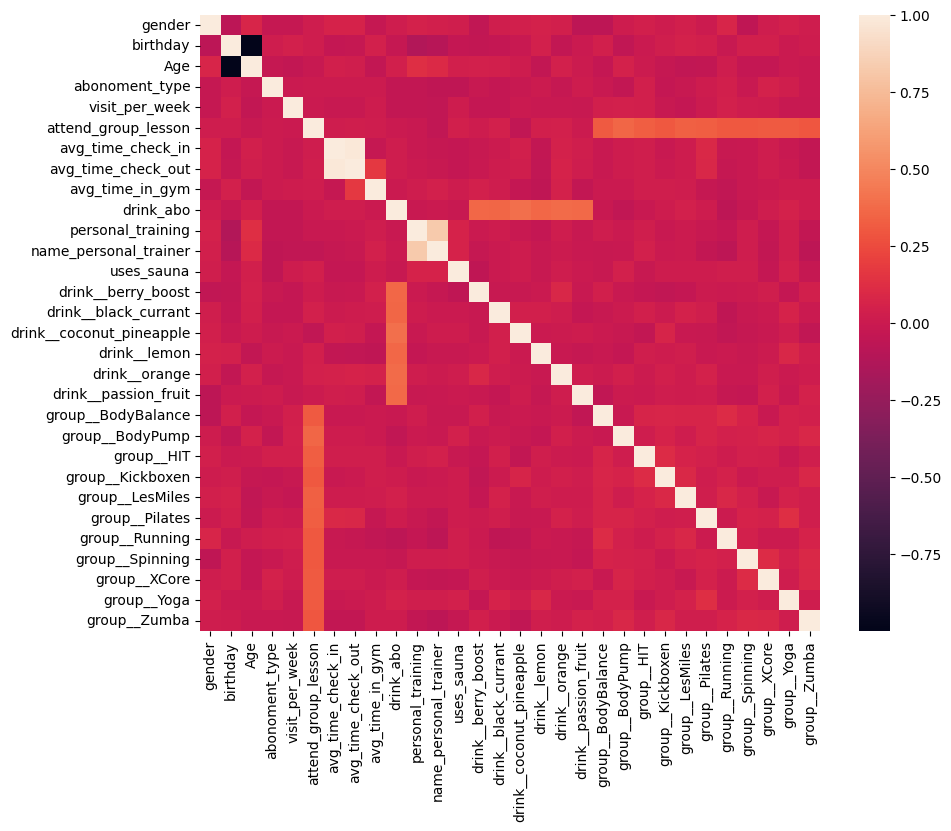

In [23]:
plt.figure(figsize=(10, 8))
sns.heatmap(gym_df.loc[:, gym_df.dtypes != 'object'].corr(), annot=False, fmt=".2f")

<Axes: xlabel='Mutual Information', ylabel='Feature'>

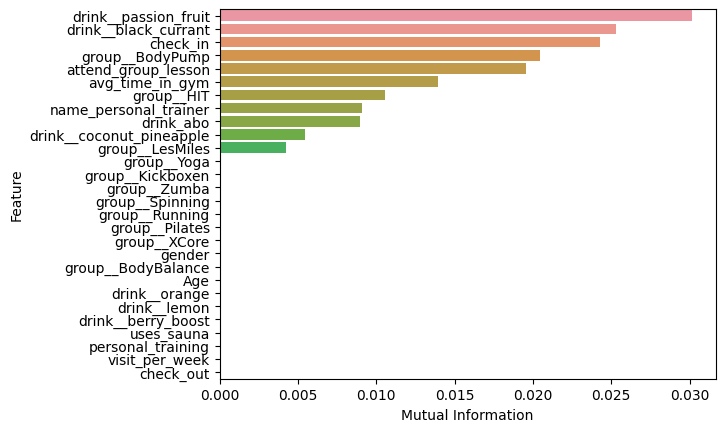

In [24]:
X = gym_df.copy()
y = X.pop('abonoment_type')
X['check_in'] = gym_df['avg_time_check_in'].dt.total_seconds()
X['check_out'] = gym_df['avg_time_check_out'].dt.total_seconds()
X.drop(['birthday', 'avg_time_check_in', 'avg_time_check_out', 'days_per_week'], inplace=True, axis='columns')
mi_scores = mutual_info_classif(X, y, random_state=42)
mi_scores = pd.DataFrame({
    'Feature': X.columns,
    'Mutual Information': mi_scores
}).sort_values(by='Mutual Information', ascending=False)
sns.barplot(x='Mutual Information', y='Feature', data=mi_scores)

<Axes: xlabel='Mutual Information', ylabel='Feature'>

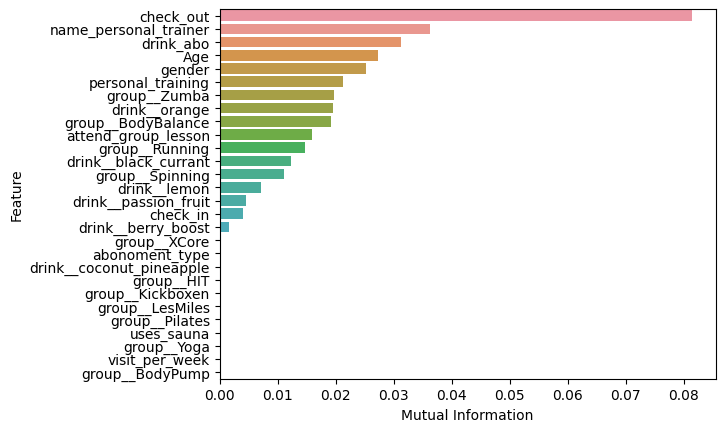

In [25]:
X = gym_df.copy()
y = X.pop('avg_time_in_gym')
X['check_in'] = gym_df['avg_time_check_in'].dt.total_seconds()
X['check_out'] = gym_df['avg_time_check_out'].dt.total_seconds()
X.drop(['birthday', 'avg_time_check_in', 'avg_time_check_out', 'days_per_week'], inplace=True, axis='columns')
mi_scores = mutual_info_regression(X, y, random_state=42)
mi_scores = pd.DataFrame({
    'Feature': X.columns,
    'Mutual Information': mi_scores
}).sort_values(by='Mutual Information', ascending=False)
sns.barplot(x='Mutual Information', y='Feature', data=mi_scores)

<Axes: >

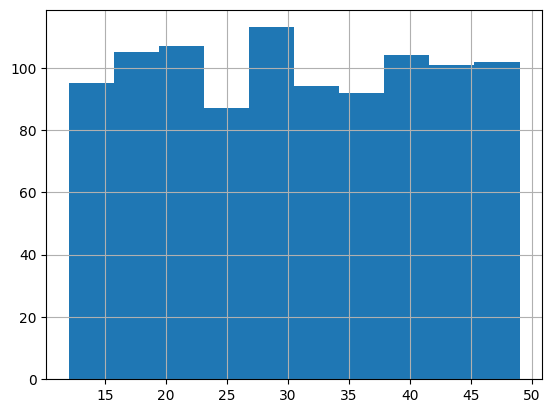

In [26]:
gym_df['Age'].hist()

In [27]:
# Wow, that's unexpected. There is no difference between old and young members.
# They are equally active.

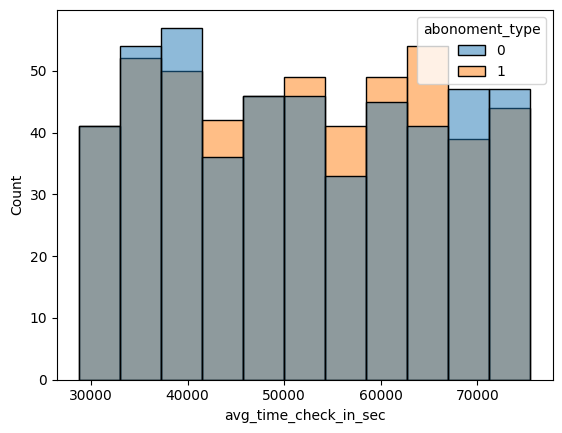

In [28]:
gym_df['avg_time_check_in_sec'] = gym_df['avg_time_check_in'].dt.total_seconds()
sns.histplot(data=gym_df, x='avg_time_check_in_sec', hue='abonoment_type')
gym_df = gym_df.drop('avg_time_check_in_sec', axis='columns')

<Axes: xlabel='Age', ylabel='visit_per_week'>

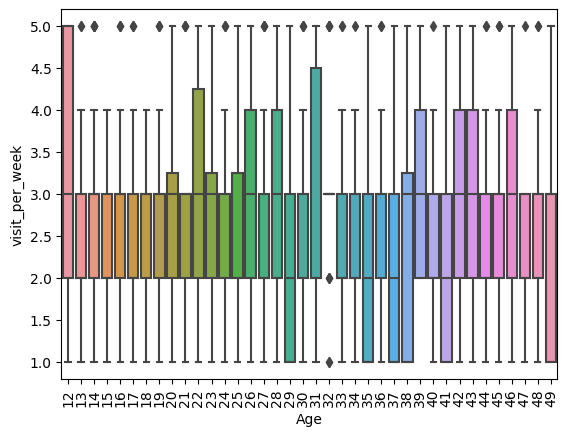

In [29]:
ax = sns.boxplot(data=gym_df, x='Age', y='visit_per_week')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax

<Axes: xlabel='Age', ylabel='avg_time_in_gym'>

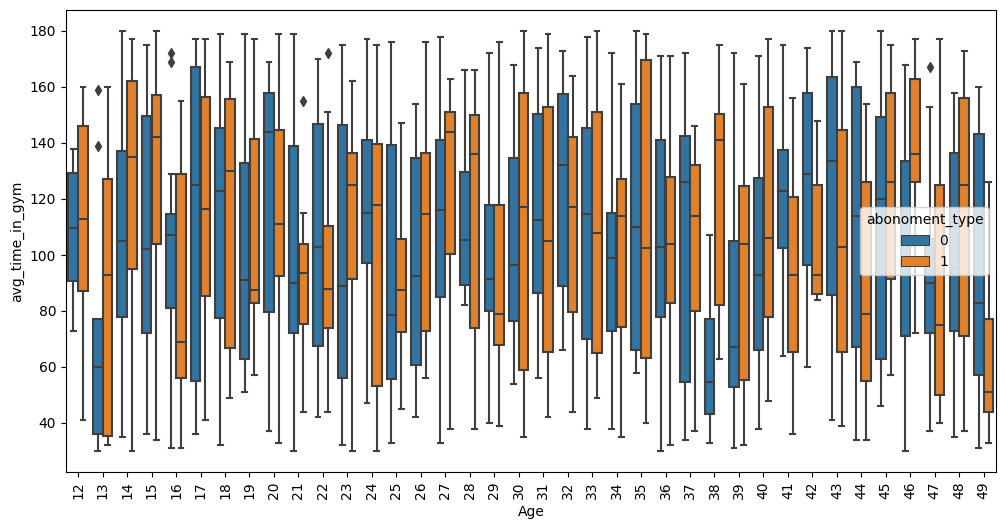

In [30]:
plt.figure(figsize=(12, 6)) 
ax = sns.boxplot(data=gym_df, x='Age', y='avg_time_in_gym', hue='abonoment_type')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax

<Axes: xlabel='gender', ylabel='count'>

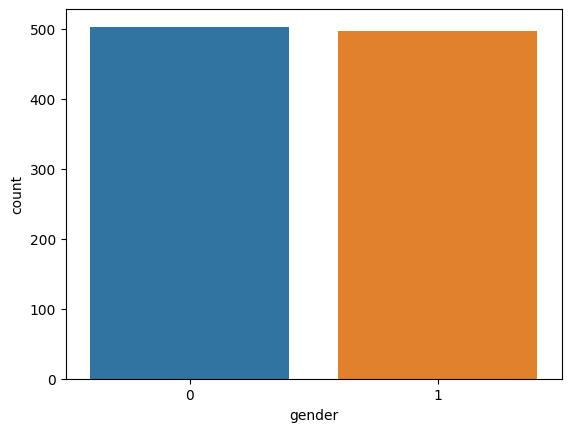

In [31]:
sns.countplot(gym_df, x='gender')

In [32]:
# Great, female and male are equally active

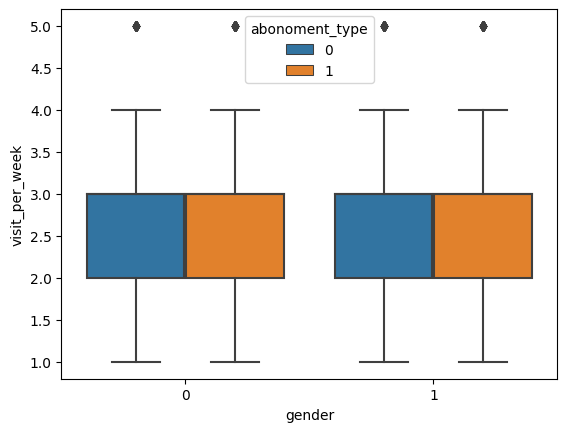

In [33]:
ax = sns.boxplot(data=gym_df, x='gender', y='visit_per_week', hue='abonoment_type')

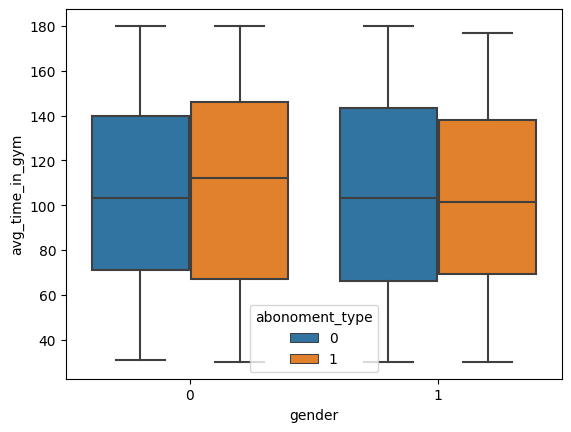

In [34]:
ax = sns.boxplot(data=gym_df, x='gender', y='avg_time_in_gym', hue='abonoment_type')

<Axes: xlabel='abonoment_type', ylabel='count'>

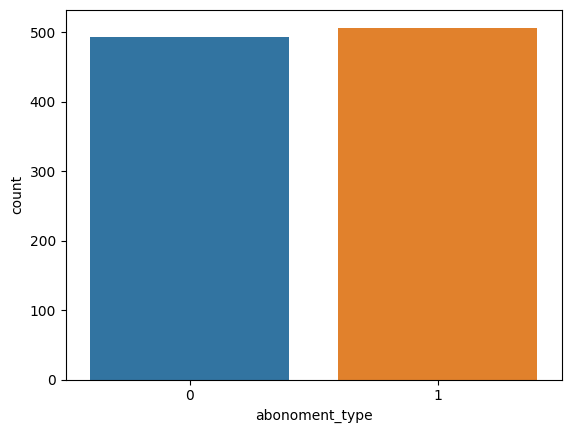

In [35]:
sns.countplot(gym_df, x='abonoment_type')

<Axes: xlabel='abonoment_type', ylabel='avg_time_in_gym'>

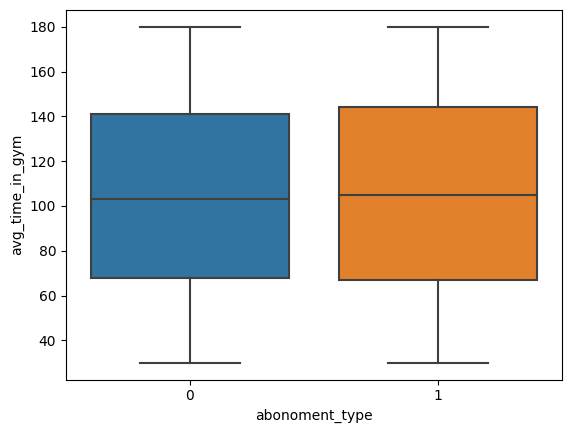

In [36]:
sns.boxplot(data=gym_df, x='abonoment_type', y='avg_time_in_gym')

<Axes: xlabel='abonoment_type', ylabel='visit_per_week'>

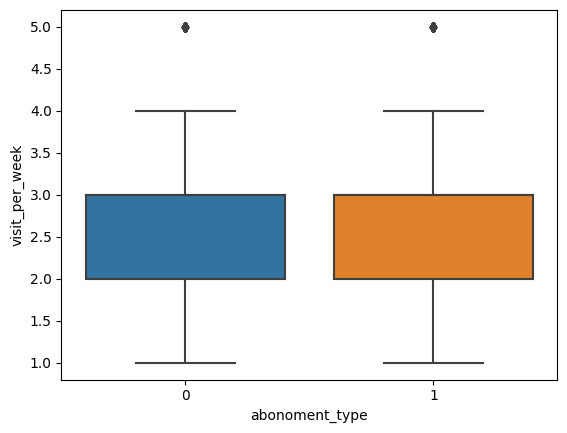

In [37]:
sns.boxplot(data=gym_df, x='abonoment_type', y='visit_per_week')

<Axes: xlabel='Age', ylabel='Count'>

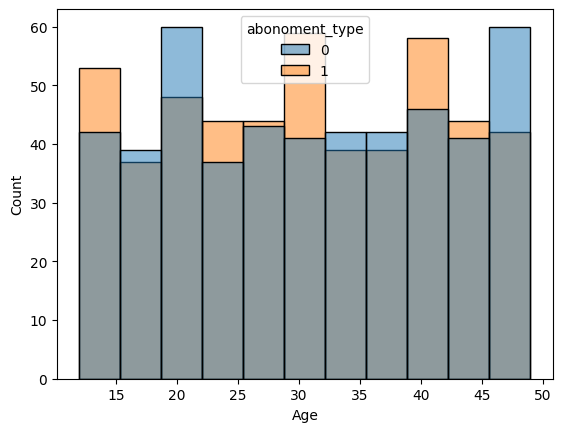

In [38]:
# warnings.filterwarnings("ignore", category=FutureWarning)
sns.histplot(data=gym_df, x='Age', hue='abonoment_type')

<Axes: xlabel='name_personal_trainer', ylabel='count'>

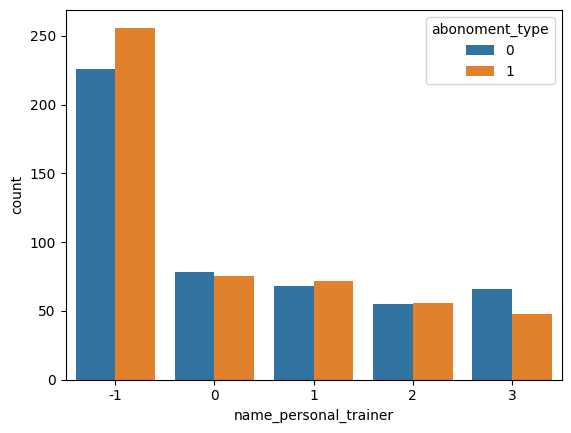

In [39]:
sns.countplot(gym_df, x='name_personal_trainer', hue='abonoment_type')

<Axes: xlabel='name_personal_trainer', ylabel='avg_time_in_gym'>

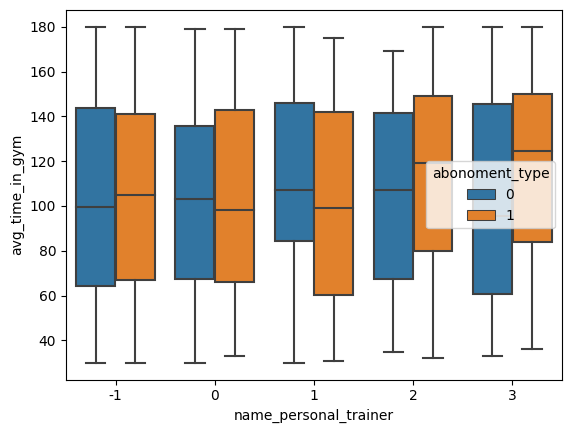

In [40]:
sns.boxplot(gym_df, x='name_personal_trainer', y='avg_time_in_gym', hue='abonoment_type')

In [41]:
def draw_abonement_counter(col_prefix):
    new_col_name = col_prefix.replace('_', '')
    group_columns = [col for col in gym_df.columns if col.startswith(col_prefix)]
    df_melted = gym_df.melt(id_vars=['abonoment_type'], value_vars=group_columns, 
                        var_name=new_col_name, value_name='participation')

    df_filtered = df_melted[df_melted['participation'] == 1]
    ax = sns.countplot(data=df_filtered, x=new_col_name, hue='abonoment_type')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    ax

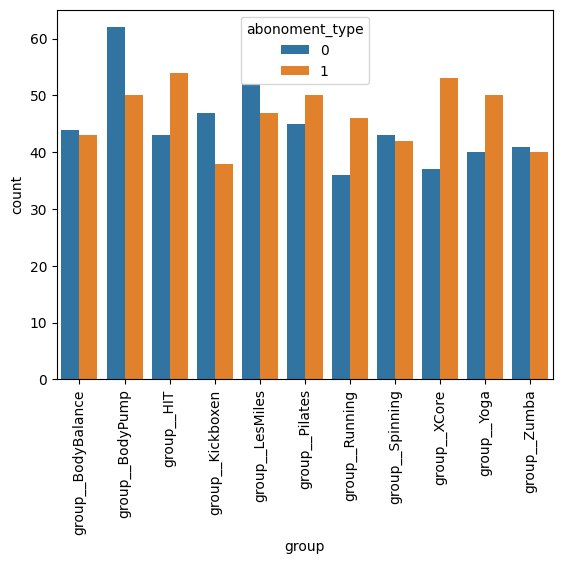

In [42]:
draw_abonement_counter('group_')

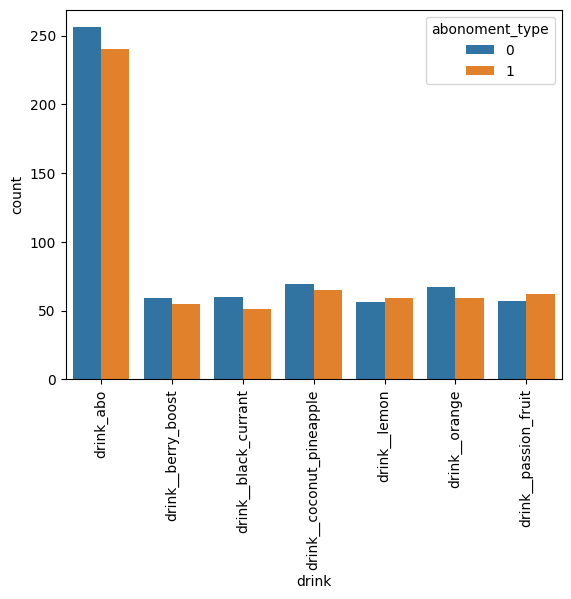

In [43]:
draw_abonement_counter('drink_')

<Axes: xlabel='total_benefits_count', ylabel='Count'>

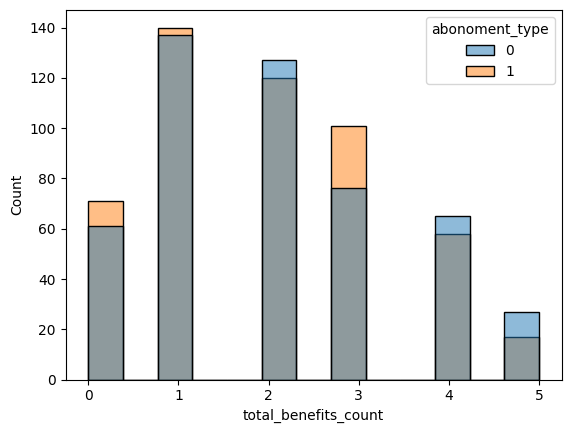

In [44]:
benefits_cols = [col for col in gym_df.columns if col.startswith('group_')]
benefits_cols += ['uses_sauna', 'personal_training']
gym_df['total_benefits_count'] = gym_df[benefits_cols].sum(axis='columns')
sns.histplot(gym_df, x='total_benefits_count', hue='abonoment_type')

<Axes: xlabel='uses_sauna', ylabel='count'>

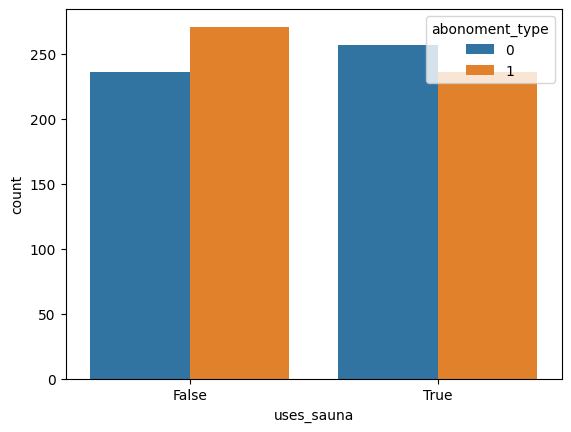

In [45]:
sns.countplot(gym_df, x='uses_sauna', hue='abonoment_type')

<Axes: xlabel='uses_sauna', ylabel='avg_time_in_gym'>

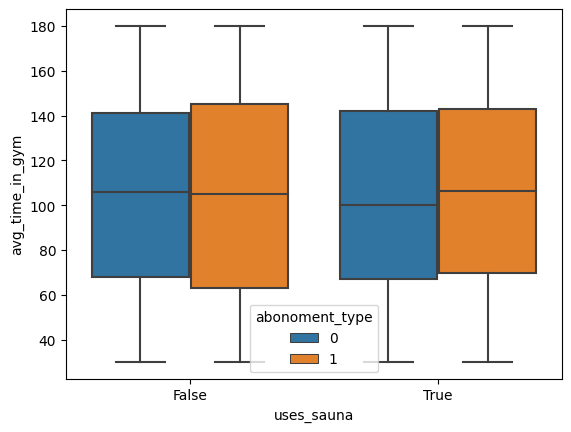

In [46]:
sns.boxplot(gym_df, x='uses_sauna', y='avg_time_in_gym', hue='abonoment_type')

<Axes: xlabel='attend_group_lesson', ylabel='avg_time_in_gym'>

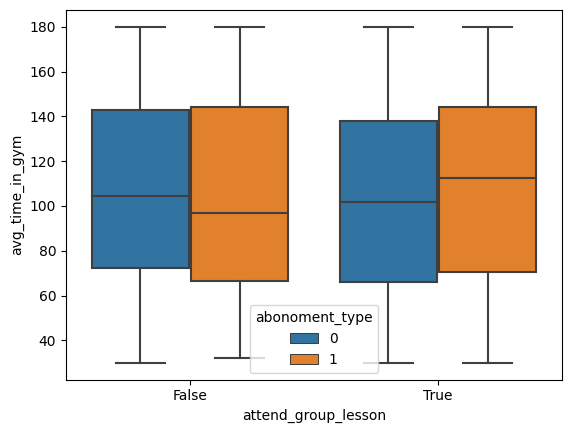

In [47]:
sns.boxplot(gym_df, x='attend_group_lesson', y='avg_time_in_gym', hue='abonoment_type')

In [51]:
pca = PCA()
X = gym_df.copy()
y = X.pop('abonoment_type')
X.drop(['birthday', 'avg_time_check_in', 'avg_time_check_out', 'days_per_week'], inplace=True, axis='columns')
X['check_in'] = gym_df['avg_time_check_in'].dt.total_seconds()
X['check_out'] = gym_df['avg_time_check_out'].dt.total_seconds()
X_scaled = (X - X.mean(axis=0)) / X.std(axis=0)
X_pca = pca.fit_transform(X_scaled)

component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
X_pca = pd.DataFrame(X_pca, columns=component_names)
mi_scores = mutual_info_classif(X, y, random_state=42)
mi_scores = pd.Series(mi_scores, name="MI Scores", index=X_pca.columns)
mi_scores.sort_values(ascending=False)

PC17    0.033624
PC23    0.029883
PC19    0.027517
PC9     0.022566
PC24    0.021488
PC10    0.020459
PC25    0.019358
PC28    0.019259
PC6     0.013541
PC5     0.012564
PC11    0.012498
PC3     0.007228
PC14    0.005627
PC2     0.003437
PC8     0.003359
PC26    0.002904
PC22    0.002426
PC4     0.000533
PC27    0.000000
PC1     0.000000
PC15    0.000000
PC21    0.000000
PC20    0.000000
PC18    0.000000
PC16    0.000000
PC13    0.000000
PC12    0.000000
PC7     0.000000
PC29    0.000000
Name: MI Scores, dtype: float64

In [52]:
pca = PCA()
X = gym_df.copy()
y = X.pop('avg_time_in_gym')
X.drop(['birthday', 'avg_time_check_in', 'avg_time_check_out', 'days_per_week'], inplace=True, axis='columns')
X['check_in'] = gym_df['avg_time_check_in'].dt.total_seconds()
X['check_out'] = gym_df['avg_time_check_out'].dt.total_seconds()
X_scaled = (X - X.mean(axis=0)) / X.std(axis=0)
X_pca = pca.fit_transform(X_scaled)

component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
X_pca = pd.DataFrame(X_pca, columns=component_names)
mi_scores = mutual_info_regression(X, y, random_state=42)
mi_scores = pd.Series(mi_scores, name="MI Scores", index=X_pca.columns)
mi_scores.sort_values(ascending=False)

PC29    0.082889
PC6     0.036092
PC11    0.035108
PC1     0.029321
PC2     0.028392
PC5     0.024369
PC14    0.016874
PC16    0.012318
PC25    0.011654
PC22    0.010898
PC21    0.009020
PC28    0.005926
PC17    0.005844
PC3     0.005591
PC10    0.005332
PC8     0.002834
PC19    0.002655
PC27    0.002485
PC13    0.002439
PC15    0.001046
PC23    0.000130
PC12    0.000000
PC4     0.000000
PC18    0.000000
PC20    0.000000
PC9     0.000000
PC24    0.000000
PC26    0.000000
PC7     0.000000
Name: MI Scores, dtype: float64

In [ ]:
pd.DataFrame(
    pca.components_.T,
    columns=component_names,
    index=X.columns,
)

In [56]:
gym_df['days_per_week'].str.split(', ').explode().value_counts(normalize=True)

days_per_week
Sun    0.151752
Wed    0.149142
Tue    0.145787
Sat    0.141685
Thu    0.141312
Fri    0.140194
Mon    0.130127
Name: proportion, dtype: float64

In [65]:
time_intervals = pd.timedelta_range(start='08:00:00', end='24:00:00', freq='1h')
time_counts = pd.DataFrame({'time_interval': time_intervals, 'class_0': 0, 'class_1': 0})

for i, row in gym_df.iterrows():
    for j in range(len(time_intervals) - 1):
        if (row['avg_time_check_in'] <= time_intervals[j + 1]) and (row['avg_time_check_out'] >= time_intervals[j]):
            time_counts.loc[j, 'class_' + str(row['abonoment_type'])] += 1

time_counts_long = time_counts.melt(id_vars='time_interval', var_name='class', value_name='count')

<Axes: xlabel='time_interval', ylabel='count'>

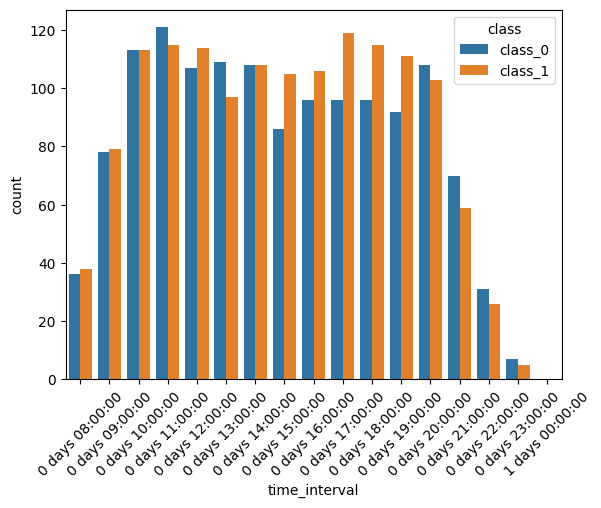

In [69]:
ax = sns.barplot(data=time_counts_long, x='time_interval', y='count', hue='class')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
ax